# Data Drift Dashboard
Here we will go back to using EvidentlyAI to create a proof of concept data drift dashboard. We will use the full training data as reference and the full five validation cohorts as analysis for this example.

In [1]:
import pickle
import numpy as np
import re
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt;
import warnings; warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import os
import sys
import gcsfs
sys.path.append(os.path.abspath("/home/jupyter/POM-feature-drift"))

In [2]:
import nannyml as nml
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset
from evidently import ColumnMapping

In [3]:
# Full reference data, will need to generate different reports for different treatments as the models are trained on different data.
ref = pd.read_csv('gs://andrew-pom/Revenue/ta_step_up_v2_clean.csv', low_memory = False)

In [4]:
ref.treatment_type.value_counts()

NT    455582
L      71951
M      71487
H      71466
Name: treatment_type, dtype: int64

## LOW TA
Just doing the one treatment as a test, will look more into how to run it for the different treatments 

### Using built in EvidentlyAI dashboards

In [5]:
analysis = pd.read_csv('data/ta_low_reference_full.csv', low_memory = False)

In [6]:
analysis.timestamp = pd.to_datetime(analysis.timestamp)
analysis.sort_values(by = 'timestamp', inplace = True)

In [7]:
with open('pickle_files/DTV_UK_ta_L.pkl', 'rb') as pkl_file:
    model = pickle.load(pkl_file)
features = model.feature_name_

In [8]:
low_ref = ref[ref.treatment_type == 'L']
dates = []
for index in low_ref.ind:
    dates.append(index.split('-')[0])

timestamps = []
for i, date in enumerate(dates):
    timestamps.append(pd.to_datetime(str(dates[i]) + '-0', format = '%Y%W-%w'))
low_ref['timestamp'] = timestamps
low_ref = low_ref[features + ['timestamp']]

In [9]:
low_ref.sort_values(by = 'timestamp', inplace = True)

In [37]:
# column_mapping = ColumnMapping()
# column_mapping.datetime = 'timestamp'

In [9]:
drift_report = Report(metrics=[DataDriftPreset()])

In [10]:
drift_report.run(reference_data = low_ref, current_data = analysis[features])

In [48]:
drift_report.save_html('drift_reports/ta_low.html')

In [51]:
drift_report.save_json('drift_reports/ta_low.json')

### Create custom plots for dashboard POC
The idea of this test is to think about what we would want displayed on a Tableau dashboard. 

For the drift score over time, could either get the required information out of the JSON file and into a BigQuery table for use in Tableau, or see if we can implement into Tableau directly from the JSON.

Also want performance estimation over time on the dashboard. We are unable to do this how we want for a proof of concept as the performance estiamtion calculator is trained on the validation data (which we are using as our mock EOO data in this test) rather than the training data. In practise, our plot will include mean ROC_AUC performance estimation scores for the validation cohorts as reference, and then the same for each EOO cohort updated each month. This will allow us to see the change to estimated performance in context compared to the validation.

For the purpose of this test, will do the performance estimation plots as in validation_data_test.ipynb, with three validation cohorts as reference and two validation cohorts as analysis.

In [19]:
sorted_features = features.copy()

In [20]:
sorted_features.sort()

Data Drift

In [11]:
validation_cohorts = ['202045-202052', '202053-202107', '202108-202111', '202116-202119', '292124-202127']

for cohort in validation_cohorts:
    gcs_path = f'gs://andrew-pom/Revenue/ta_step_up_low_v2_{cohort}_oot.csv'
    cohort_df = pd.read_csv(gcs_path, low_memory = False)

    dates = []
    for index in cohort_df.ind:
        dates.append(index.split('-')[0])

    timestamps = []
    for i, date in enumerate(dates):
        timestamps.append(pd.to_datetime(str(dates[i]) + '-0', format = '%Y%W-%w'))
    cohort_df['timestamp'] = timestamps

    cohort_df.drop(columns = ['ind', 'xgb_preds', 'xgb_proba', 'logr_preds', 'logr_proba'], inplace = True)
    cohort_df.rename(columns = {'lgbm_preds': 'pred_ta', 'lgbm_proba': 'pred_proba_ta'}, inplace = True)
    cohort_df.sort_values(by = 'timestamp', inplace = True)
    
    drift_report.run(reference_data = low_ref, current_data = cohort_df[features])
    drift_report.save_json(f'drift_reports/ta_low_{cohort}.json')

In [10]:
import json

In [36]:
plot_df = pd.DataFrame()

In [37]:
# Creates DataFrame that can be used for our analysis over time tables.
validation_cohorts = ['202045-202052', '202053-202107', '202108-202111', '202116-202119', '292124-202127']
for cohort in validation_cohorts:
    df = pd.DataFrame(data = {'Feature': features, 'Stattest': None, 'Drift_Score': None, 'Cohort': None})
    for i, feature in enumerate(features):
        with open(f'drift_reports/ta_low_{cohort}.json', 'r') as file:
            report = json.load(file)
        
        #df.Feature = features
        df.iloc[i, 1] = report['metrics'][1]['result']['drift_by_columns'][feature]['stattest_name']
        df.iloc[i, 2] = report['metrics'][1]['result']['drift_by_columns'][feature]['drift_score']
        df.iloc[i, 3] = cohort
        
    plot_df = pd.concat([plot_df, df])
plot_df.reset_index(inplace = True, drop = True)

Performance Estimation

In [31]:
# Setup analysis data
analysis_cohorts = ['202116-202119', '292124-202127']
df = pd.DataFrame()
for cohort in analysis_cohorts:
    gcs_path = f'gs://andrew-pom/Revenue/ta_step_up_low_v2_{cohort}_oot.csv'
    cohort_df = pd.read_csv(gcs_path, low_memory = False)
    df = pd.concat([df, cohort_df])
    
dates = []
for index in df.ind:
    dates.append(index.split('-')[0])
    
timestamps = []
for i, date in enumerate(dates):
    timestamps.append(pd.to_datetime(str(dates[i]) + '-0', format = '%Y%W-%w'))
df['timestamp'] = timestamps

df.drop(columns = ['ind', 'xgb_preds', 'xgb_proba', 'logr_preds', 'logr_proba'], inplace = True)
df.rename(columns = {'lgbm_preds': 'pred_ta', 'lgbm_proba': 'pred_proba_ta'}, inplace = True)
df.sort_values(by = 'timestamp', inplace = True)

In [33]:
# Setup reference data
ref = pd.read_csv('data/ta_low_reference_validation.csv', low_memory = False)
ref.timestamp = pd.to_datetime(ref.timestamp)
ref.sort_values(by = 'timestamp', inplace = True)

In [34]:
estimator = nml.CBPE(y_pred_proba = 'pred_proba_ta',
                         y_pred = 'pred_ta',
                         y_true = 'target_ta',
                         metrics = ['roc_auc'],
                         timestamp_column_name = 'timestamp',
                         chunk_period = 'W',
                         # chunk_number = 10,
                         problem_type = 'classification_binary'
                        )

estimator = estimator.fit(ref[features + ['pred_proba_ta', 'pred_ta', 'target_ta', 'timestamp']])
estimated_performance = estimator.estimate(df[features + ['pred_proba_ta', 'pred_ta', 'timestamp']])

In [39]:
results = estimated_performance.to_df(multilevel = False)

In [62]:
results

,chunk_key,chunk_index,chunk_start_index,chunk_end_index,chunk_start_date,chunk_end_date,chunk_period,roc_auc_sampling_error,roc_auc_realized,roc_auc_value,roc_auc_upper_confidence_boundary,roc_auc_lower_confidence_boundary,roc_auc_upper_threshold,roc_auc_lower_threshold,roc_auc_alert
0,2020-11-09/2020-11-15,0,0,3587,2020-11-09,2020-11-15 23:59:59.999999999,reference,0.011110,0.733630,0.731899,0.765229,0.698569,0.763724,0.695177,False
1,2020-12-07/2020-12-13,1,3588,7310,2020-12-07,2020-12-13 23:59:59.999999999,reference,0.010907,0.716416,0.728412,0.761132,0.695692,0.763724,0.695177,False
2,2021-01-04/2021-01-10,2,7311,10179,2021-01-04,2021-01-10 23:59:59.999999999,reference,0.012424,0.720591,0.731129,0.768403,0.693856,0.763724,0.695177,False
3,2021-01-25/2021-01-31,3,10180,13297,2021-01-25,2021-01-31 23:59:59.999999999,reference,0.011918,0.719523,0.729695,0.765449,0.693941,0.763724,0.695177,False
4,2021-02-22/2021-02-28,4,13298,17088,2021-02-22,2021-02-28 23:59:59.999999999,reference,0.010808,0.738989,0.729020,0.761445,0.696595,0.763724,0.695177,False
5,2021-03-22/2021-03-28,5,17089,20516,2021-03-22,2021-03-28 23:59:59.999999999,reference,0.011366,0.747553,0.737750,0.771849,0.703651,0.763724,0.695177,False
6,2021-04-19/2021-04-25,0,0,3410,2021-04-19,2021-04-25 23:59:59.999999999,analysis,0.011395,NaN,0.732822,0.767006,0.698638,0.763724,0.695177,False
7,2021-05-17/2021-05-23,1,3411,10380,2021-05-17,2021-05-23 23:59:59.999999999,analysis,0.007971,NaN,0.739177,0.763090,0.715263,0.763724,0.695177,False
8,2021-06-14/2021-06-20,2,10381,15727,2021-06-14,2021-06-20 23:59:59.999999999,analysis,0.009101,NaN,0.737633,0.764936,0.710330,0.763724,0.695177,False


In [69]:
# Manual method for including mean performance estimation in plot data table, will be automatic in practise as table will update each month so will
# not need to worry about timestamp <-> cohort conversions.
plot_df['Mean_Estimated_ROC_AUC'] = None

def f(x):
    if x.Cohort == '202045-202052': return sum([results.iloc[0, 9], results.iloc[1, 9]])/2
    elif x.Cohort == '202053-202107': return sum([results.iloc[2, 9], results.iloc[3, 9]])/2
    elif x.Cohort == '202108-202111': return sum([results.iloc[4, 9], results.iloc[5, 9]])/2
    elif x.Cohort == '202116-202119': return sum([results.iloc[6, 9], results.iloc[7, 9]])/2
    elif x.Cohort == '292124-202127': return results.iloc[8, 9]

plot_df['Mean_Estimated_ROC_AUC'] = plot_df.apply(f, axis = 1)
plot_df.head()

,Feature,Stattest,Drift_Score,Cohort,Mean_Estimated_ROC_AUC
0,hd_active,Jensen-Shannon distance,0.099849,202045-202052,0.730155
1,arpu,Wasserstein distance (normed),0.071844,202045-202052,0.730155
2,dtv_last_activation_dt_monthdiff,Wasserstein distance (normed),0.048756,202045-202052,0.730155
3,last_ta_dt_monthdiff,Wasserstein distance (normed),0.085874,202045-202052,0.730155
4,last_offer_applied_dt_dtv_monthdiff,Wasserstein distance (normed),0.041107,202045-202052,0.730155


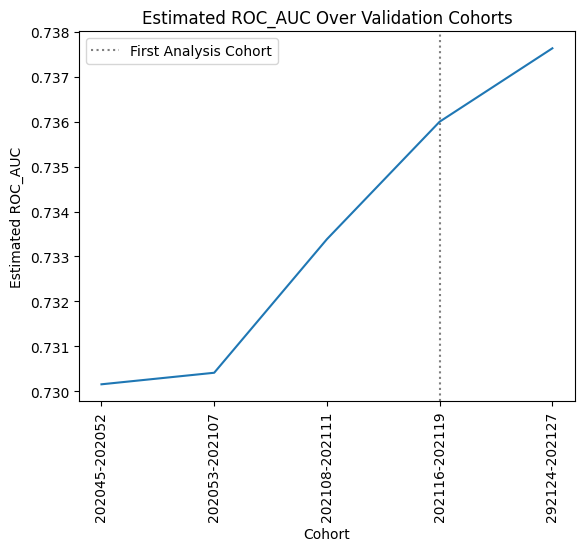

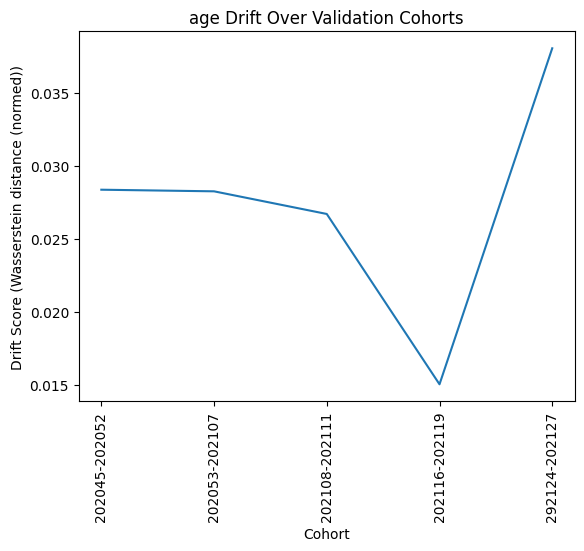

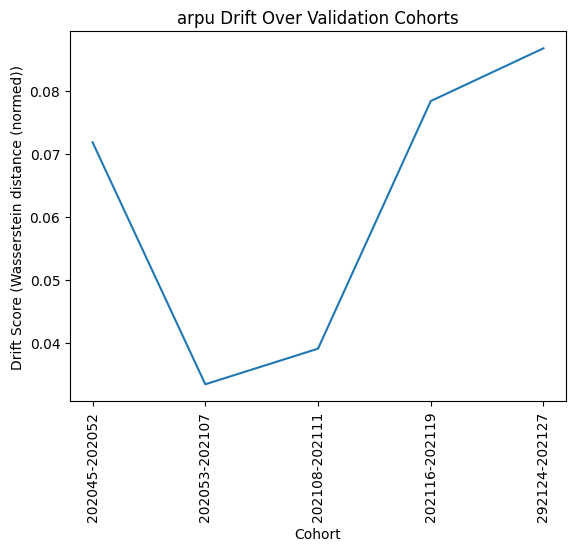

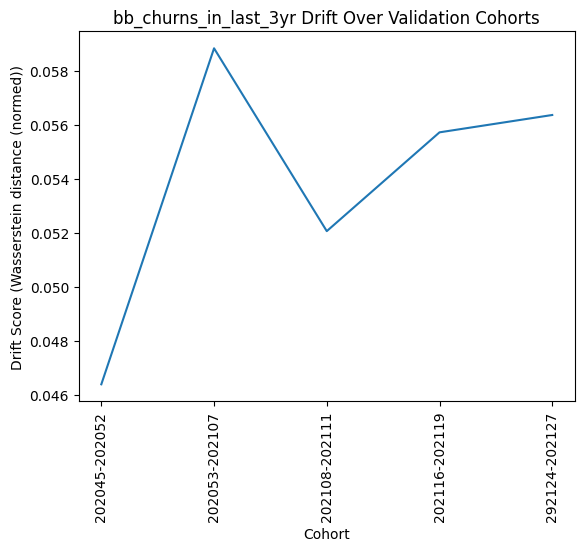

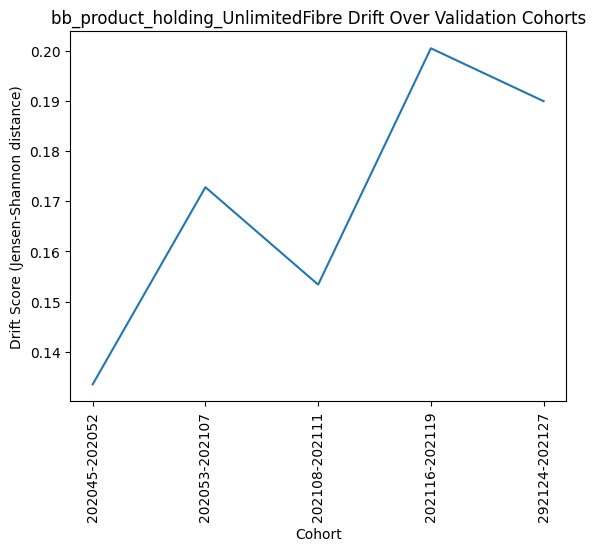

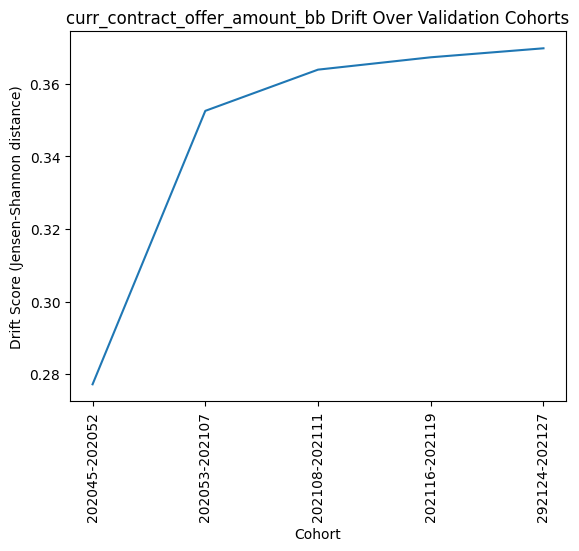

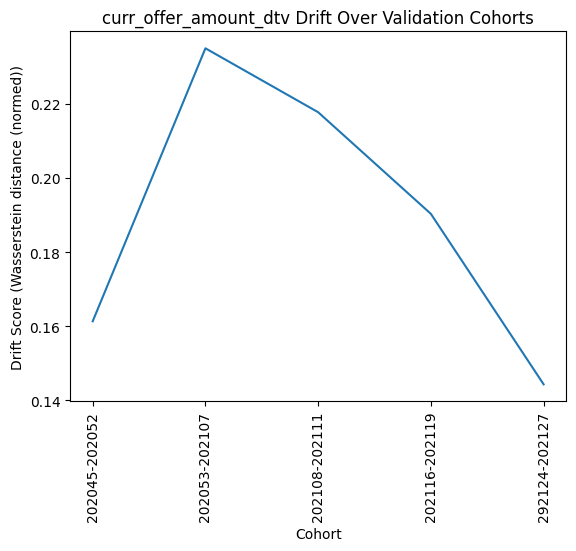

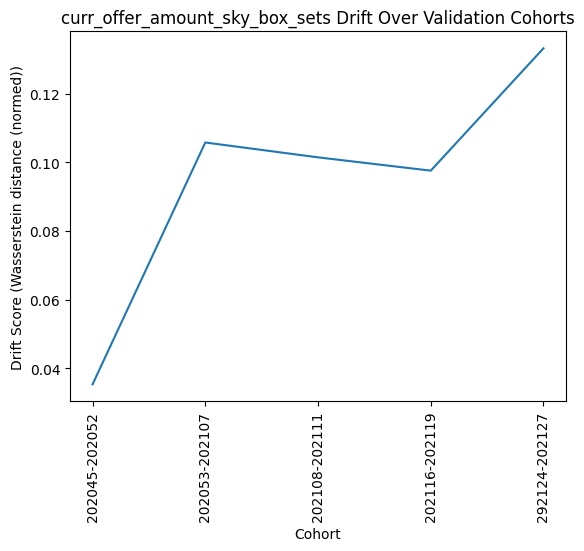

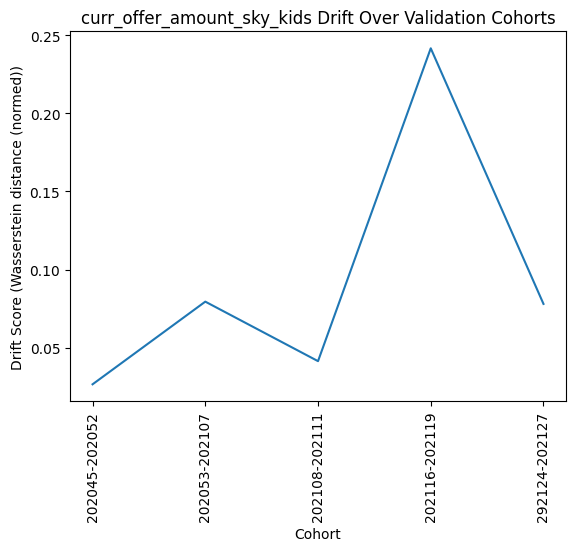

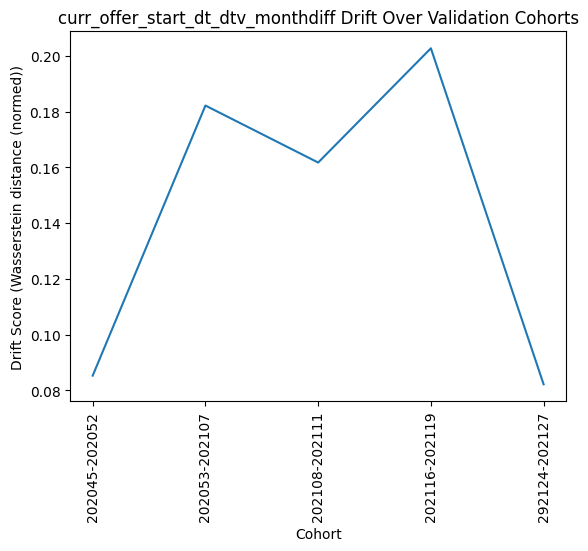

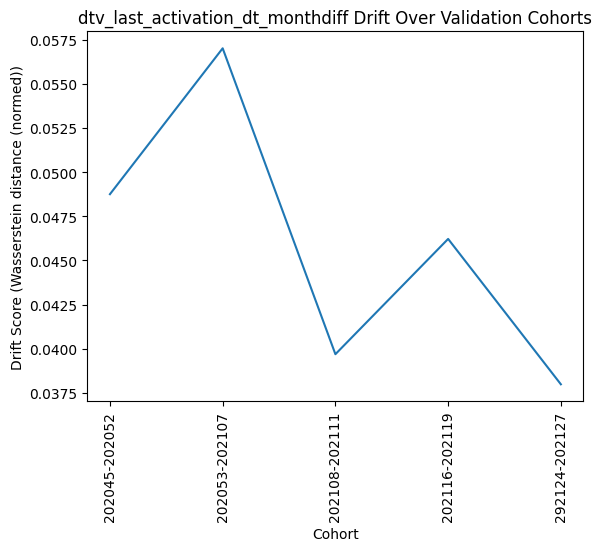

In [80]:
# Plots performance estimation over time
plt.figure()
plt.xticks(rotation = '90')
plt.ylabel(f'Estimated ROC_AUC')
plt.xlabel('Cohort')
plt.title(f'Estimated ROC_AUC Over Validation Cohorts')

plt.plot(plot_df.Cohort.unique(), plot_df.Mean_Estimated_ROC_AUC.unique())
plt.axvline(x = '202116-202119', label = 'First Analysis Cohort', ls = ':', color= 'tab:grey')
plt.legend()
plt.show()

# Creates plot of drift score over time for top N features (ranked by LGBM feature importance)
N = 10
for feature in sorted_features[:N]:
    data = drift_df[drift_df.Feature == feature].sort_values(by = 'Cohort')
    plt.figure()
    plt.xticks(rotation = '90')
    plt.ylabel(f'Drift Score ({list(data.Stattest)[0]})')
    plt.xlabel('Cohort')
    plt.title(f'{feature} Drift Over Validation Cohorts')
    plt.plot(data.Cohort, data.Drift_Score, color = 'tab:blue')
plt.show()